<a href="https://colab.research.google.com/github/netq-oist/estimation-public/blob/main/Estimation_of_w.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble
Given a state of Werner form $\rho_w = (1-w)|\Phi^+\rangle\langle \Phi^+| + \frac{w}{4}\mathbb{I}$, the aim is to estimate the value of $w$. We consider, estimation of $w$ from the measurement statistics of a distillation protocol. The distillation protocol is as follows.
1) Alice and Bob start with two copies of a noisy entangled state. Here, we assume that the state is a Werner state.

2) Each applies local XOR operations on the local parts of their two copies, with one copy as the control and another one as the target.

3) Each of them measures the target qubit in the $Z$-basis and communicates the results classically.

4) If they obtain correlated outcomes i.e, $00,11$ they keep the unmeasured copy, otherwise they discard the state.

From this $p_{00}$ our aim is to invert $w$ even in presence of noise.

In [1]:
import numpy as np
import math as mt
import numpy.linalg as nl
import functools
import random

import matplotlib.pyplot as plt

def multikron(arrays):
  return functools.reduce(np.kron, arrays)

# up-down states
up = np.matrix([[1.0],[0.0]])
down = np.matrix([[0.0],[1.0]])

# Pauli matrices
s0 = np.matrix([[1.0, 0.0],[0.0, 1.0]])      # I_2
s1 = np.matrix([[0.0, 1.0],[1.0, 0.0]])      # Pauli-X
s2 = np.matrix([[0.0, -1j],[1j, 0.0]])       # Pauli-Y
s3 = np.matrix([[1.0, 0.0],[0.0, -1.0]])     # Pauli-Z

# Bell states
phip = (1./mt.sqrt(2.0)) * np.matrix([ [1.], [0.], [0.], [1.]])
phim = (1./mt.sqrt(2.0)) * np.matrix([ [1.], [0.], [0.], [-1.]])
psip = (1./mt.sqrt(2.0)) * np.matrix([ [0.], [1.], [1.], [0.]])
psim = (1./mt.sqrt(2.0)) * np.matrix([ [0.], [1.], [-1.], [0.]])

# Gates
CNOT = np.array([[1.0,0.0,0.0,0.0],
                 [0.0,1.0,0.0,0.0],
                 [0.0,0.0,0.0,1.0],
                 [0.0,0.0,1.0,0.0]]) #CNOT gate

SWAP = np.array([[1.0,0.0,0.0,0.0],
                 [0.0,0.0,1.0,0.0],
                 [0.0,1.0,0.0,0.0],
                 [0.0,0.0,0.0,1.0]])  #SWAP gate

ID = np.array([[1.0,0.0,0.0,0.0],
                 [0.0,1.0,0.0,0.0],
                 [0.0,0.0,1.0,0.0],
                 [0.0,0.0,0.0,1.0]]) # 4X4 Identity matrix


# Action of noise and calculation of probability

Werner state:  $\rho_w = (1-w)|\Phi^+\rangle\langle \Phi^+| + \frac{w}{4}\mathbb{I}$

Dephasing parameter $p = \frac{1}{2}(1-e^{-\frac{t}{T_2}})$ and depolarizing parameter $q = (1-e^{-\frac{t}{T_1}})$

Action of dephasing operation
$\Lambda_{deph} (\rho) = (1-p)\rho + p \sigma_Z \rho \sigma_Z$

Action of depolarizing operation
$\Lambda_{depol} (\rho) = (1-q)\rho + \frac{q}{2} \mathbb{I}$

Final state after the action of these two noise
$\Lambda_{depol}(\Lambda_{deph}(\rho_w))$

In order to reshuffle the state from $\rho_{A_1B_1A_2B_2}$ to $\rho_{A_1A_2B_1B_2}$, apply SWAP in $B_1A_2$ part i.e, $\mathbb{I}_{A_1} \otimes SWAP_{B_1A_2} \otimes \mathbb{I}_{A_2}$

Action of noisy CNOT on $\rho_{A_1A_2B_1B_2}$

\begin{align}
\Lambda_{\text{CNOT}}(\rho_{A_1 A_2 B_1 B_2})
=\quad &(1-y_1)(1-y_2) \,\text{CNOT}_{A_1 A_2}\otimes \text{CNOT}_{B_1 B_2} \,  \rho_{A_1A_2B_1B_2} \,\text{CNOT}_{A_1 A_2} \otimes \text{CNOT}_{B_1 B_2}\\
+ &\frac{y_2(1-y_1)}{4} \,\text{CNOT}_{A_1 A_2}\otimes I_{B_1 B_2} \,  \rho_{A_1A_2B_1B_2} \,\text{CNOT}_{A_1 A_2} \otimes I_{B_1 B_2}\\
+ &\frac{y_1(1-y_2)}{4}\,I_{A_1 A_2}\otimes\text{CNOT}_{B_1 B_2} \,  \rho_{A_1A_2B_1B_2} \,I_{A_1 A_2}\otimes\text{CNOT}_{B_1 B_2}\\
+ &\frac{y_1 y_2}{16} \mathbb{I}
\end{align}

Final state after all the noise acion is
\begin{equation}
\rho_{final} = \Lambda_{\text{CNOT}}((\mathbb{I} \otimes SWAP \otimes \mathbb{I})(\Lambda_{depol}(\Lambda_{deph}(\rho_w)) \otimes \rho_w)(\mathbb{I} \otimes SWAP \otimes \mathbb{I}))
\end{equation}

Noisy measurement:  $M_{p}= p |0\rangle\langle 0|+ (1-p)|1\rangle\langle 1|$
Probability of getting 00 outcome is given by Born rule
\begin{equation}
p_{00} = Tr[ \langle M_{p_A}|_{A_2} \langle M_{p_B}|_{B_2} (\rho_{final}) |M_{p_A}⟩_{A_2} |M_{p_B}⟩_{B_2} ]
\end{equation}

# Calculation in terms of Bell vector
$\rho = p_1 |\Phi^+\rangle\langle \Phi^+| + p_2 |\Psi^+\rangle\langle \Psi^+| + p_3 |\Phi^-\rangle\langle \Phi^-| + p_4 |\Psi^-\rangle\langle \Psi^-|$

Action of X operator: $(\mathbb{I} \otimes X)(p_1, p_2, p_3, p_4) ⇒ (p_2, p_1, p_4, p_3)$

Action of Z operator: $(\mathbb{I} \otimes Z)(p_1, p_2, p_3, p_4) ⇒ (p_3, p_4, p_1, p_2)$

Action of Y operator: $(\mathbb{I} \otimes Y)(p_1, p_2, p_3, p_4) ⇒ (p_4, p_3, p_2, p_1)$

Therefore, under dephasing: $(\Lambda_{deph})(p_1, p_2, p_3, p_4) ⇒ ((1-p_A)(1-p_B) + p_Ap_B)(p_1, p_2, p_3, p_4) + (p_A(1-p_B) + p_B(1-p_A))(p_3, p_4, p_1, p_2)$.

Under depolarising: $(\Lambda_{depol})(p_1, p_2, p_3, p_4) ⇒ (1-3q_A/4)(1-3q_B/4)(p_1, p_2, p_3, p_4)  + (q_Aq_B/16)(2(1, 1, 1, 1) + (p_1, p_2, p_3, p_4)) + ((1-3q_A/4)q_B/4 +(1-3q_B/4)q_A/4)((p_2, p_1, p_4, p_3)+(p_3, p_4, p_1, p_2)+(p_4, p_3, p_2, p_1))$.

Under CNOT: $p_1p_1' → p_1p_1', p_1p_2' → p_1p_2', p_1p_3' → p_3p_3', p_1p_4' → p_3p_4', p_2p_1' → p_2p_2', p_2p_2' → p_2p_1', p_2p_3' → p_4p_4', p_2p_4' → p_4p_3',   p_3p_1' → p_3p_1', p_3p_2' → p_3p_2', p_3p_3' → p_1p_3', p_3p_4' → p_1p_4', p_4p_1' → p_4p_2', p_4p_2' → p_4p_1', p_4p_3' → p_2p_4', p_4p_4' → p_2p_3'$ where the coefficients corresponding to the second copy are denoted by prime.

Under noisy measurement: with probability $p_{mA}p_{mB}$ and $(1-p_{mA})(1-p_{mB})$ calculate the coefficient of $|\Phi^+\rangle$ and $|\Phi^-\rangle$ and with probability $(1-p_{mA})p_{mB}$ and $p_{mA}(1-p_{mB})$ calculate the coefficient of $|\Psi^+\rangle$ and $|\Psi^-\rangle$.

In [2]:
def BellVector(p1, p2, p3, p4):
  return [p1, p2, p3, p4]

# Werner state
def getWernerState(w):
  return BellVector(1.-3.*w/4., w/4., w/4., w/4.)

# Apply X operation on Bell diagonal state
def applyXtoBellVector(vector):
  vectornew = [vector[1],vector[0],vector[3],vector[2]]
  return vectornew

# Apply Z operation on Bell diagonal state
def applyZtoBellVector(vector):
  vectornew = [vector[2],vector[3],vector[0],vector[1]]
  return vectornew

# Apply Y operation on Bell diagonal state
def applyYtoBellVector(vector):
  vectornew = [vector[3],vector[2],vector[1],vector[0]]
  return vectornew

# Dephasing parameter
def getDephasingParameter(t,T2):
  return 0.5*(1. - mt.exp(-t/T2))

# Deploarizing parameter
def getDepolarizingParameter(t,T1):
  return 1. -mt.exp(-t/T1)

# Dephasing function with Alice's parameter pA and Bob's parameter pB
def applyDephasing(inputVector,t,T2):
  pA = getDephasingParameter(t,T2) #Alice's Dephasing parameter
  pB = getDephasingParameter(t,T2) #Bob's Dephasing parameter
  return list(((1-pA)*(1-pB) + pA*pB)* np.array(inputVector) + ((1-pA)*pB + pA*(1-pB))* np.array(applyZtoBellVector(inputVector)))

# Depolarizing function with Alice's parameter qA and Bob's parameter qB
def applyDepolarizing(inputVector,t,T1):
  qA = getDepolarizingParameter(t,T1) #Alice's Depolarizing parameter
  qB = getDepolarizingParameter(t,T1) #Bob's Depolarizing parameter
  return list((1.-3.*qA/4.)*(1.-3.*qB/4.)* np.array(inputVector) + \
   (qA*qB/16)* (2*np.array([1., 1., 1., 1.]) + np.array(inputVector)) + ((1-3*qA/4)*(qB/4) + \
    (1-3*qB/4)*(qA/4))*(np.array(applyXtoBellVector(inputVector)) + \
    np.array(applyYtoBellVector(inputVector)) + np.array(applyZtoBellVector(inputVector))))

# Expression for general state after the action of dephasing and deploarizing noise
def FinalStateAfterActionOfNoise(inputState,t,T1,T2):
  return applyDepolarizing(applyDephasing(inputState,t,T2),t,T1)

# Expression of two copy state rhoA1B1A2B2 where firstcopy A1B1 will undergo noise for time t and the second copy is noise free
def rhoA1B1A2B2(inputState,t,T1,T2):
  return np.kron(applyDepolarizing(applyDephasing(inputState,t,T2),t,T1),inputState)

# State after the action of noisy CNOT@CNOT
def applyCNOT1(inputMatrix,y1,y2):
  inputMatrixNew = [inputMatrix[0], inputMatrix[1], inputMatrix[10], \
  inputMatrix[11], inputMatrix[5], inputMatrix[4], inputMatrix[15], \
  inputMatrix[14], inputMatrix[8], inputMatrix[9], inputMatrix[2], \
  inputMatrix[3], inputMatrix[13], inputMatrix[12], inputMatrix[7], inputMatrix[6]]
  return list((1-y1)*(1-y2)* np.array(inputMatrixNew) + (y1*y2/16.+(1-y1)*y2/4.+(1-y2)*y1/4.) *np.kron([1.,1.,1.,1.], [1.,1.,1.,1.]))

# Effect of Noisy Z measurement with probability p up projector and probability (1-p) down projector on A2B2 part
def NoisyMeasurement(inputVector, mA, mB):
  return (mA*mB + (1.-mA)*(1.-mB))*(1./2.)*(inputVector[0] + inputVector[2] + \
      inputVector[4] + inputVector[6] + inputVector[8] + inputVector[10] + \
      inputVector[12] + inputVector[14]) + ((1.-mA)*mB + mA*(1.-mB))*(1./2.)* \
      (inputVector[1] + inputVector[3] + inputVector[5] + inputVector[7] + \
      inputVector[9] + inputVector[11] + inputVector[13] + inputVector[15])

# probability after noisy measurement on A2B2 part
def p00(w,t,T1,T2,y1,y2,mA,mB):
  return NoisyMeasurement(applyCNOT1(rhoA1B1A2B2(getWernerState(w),t,T1,T2),y1,y2),mA,mB)

# Place all input variables here

For simulation of experiment

In [3]:
wexp = 0.0 # Here w need to choosen for simulation of experiment but obviously not for estimation

# Some useful numbers
eps = 1e-5
epsilon = 0.01

# Parameter related to dephasing and depolarizing noise
T1 = 100.0
T2 = 100.0

# Initial parameter for noisy CNOT
y1 = 0.1
y2 = 0.1

#Noisy measurement
mA = 0.9
mB = 0.9

# Expeimental parameters
Nsamples = 100
pSuccess = 0.1
#p00exp = ncount/Nsamples
#tave = 1


# Simulation of experiment for evaluating p00exp

After the first copy has been generated one need to wait (say) $t$ times for the second copy. And this $t$ will follow some geometric distribution with success probability $p_{success}$. If Nsamples is the number of times the distillation experment goes on, then we can calculate the probability of obtaining outcome 00 by the following simulation.



In [4]:
# This is new definition of p00 to get rid of other noise parameters
def p00Expected(w,t):
  return p00(w,t,T1,T2,y1,y2,mA,mB)

np.random.seed(8888)
# generate t array (geometric distribution) and x array (uniform distribution)
tArray = np.random.geometric(pSuccess, Nsamples)
#tArray=[2,3,6,2,3,4,5,2,3,5]

# Calculating p00 average which we will use for inverting p00 to w
def p00samples(w, Nsamples, tArray):
  # p00 sum over i
  p00sum = 0.

  i = 0

  while i < Nsamples:
    # calculate p00 per instance i
    p00sum += p00Expected(w,tArray[i])

    i += 1

  return p00sum/Nsamples

# Simulation of experiment by calculating p00 by performing the experiment Nsamples time where t is choosen from geometric distribution
def p00Experimental(wexp, Nsamples, pSuccess, tArray):
  # initialize counting 00's
  Ncount = 0.
  i = 0

  while i < Nsamples:
    # we count the 00's
    # uniformly sample for some success probability
    x = random.uniform(0.,1.)

    # compare the success probabilty
    if x < p00Expected(wexp, tArray[i]):
      # count successful p00's
      Ncount +=1

    i += 1

  # calculation of p00exp
  return Ncount/Nsamples

# This is just for checking if instead of smulating experiment we get actual p00 value corresponding to w in presence of all kind of noise
def p00expn(wexp):
  i = 0
  p00expNew = 0
  while i < Nsamples:
    p00expNew += p00Expected(wexp, tArray[i])
    i = i+1
  return p00expNew/Nsamples
p00exp2 = p00expn(wexp)

# Inverting p00 to estimate w
We use bisection method for inverting from $p_{00}$ to $w$

In [5]:
p00exp = p00Experimental(wexp, Nsamples, pSuccess, tArray)

# Inverting p00 to Werner parameter
def invertWernerParam(p00exp, tArray, eps):
  # initialize the w boundary values
  wl = 0.
  wr = 1.

  # Calculate for the corresponding hat{p}_00 values
  p00l = p00samples(wl, Nsamples, tArray)
  p00r = p00samples(wr, Nsamples, tArray)

  # count iterations
  i = 0

  # convergence test
  nLim = np.ceil(np.log2(1./eps))

  # Pick the left value to compare with p00exp
  while abs(p00l - p00exp) > eps:
    # Binary search
    # Take w midpoint and calculate corresponding p00est
    wm = (wr + wl)/2.
    p00m = p00samples(wm, Nsamples, tArray)
    #print(p00m)

    # Change the boundaries
    # Use the fact that over the range w = [0,1), p00 is monotonically decreasing
    if p00m > p00exp:
      wl = wm
      p00l = p00m
    else:
      wr = wm
      p00r = p00m

    if i > nLim:
      break

    i += 1

  return wl

In [ ]:
print(invertWernerParam(p00exp, tArray, eps))
print(invertWernerParam(p00exp2, tArray, eps))

# Calculation for Hoeffdings inequality

For $|\hat{p}_{00} - p_{00}|  \geq \epsilon$ here we calculate what will be $\epsilon'$ where $\epsilon' \equiv |\hat{w}-w|$ and with what probability i.e, $Pr(|\hat{w}-w| \geq ϵ')$.

In [ ]:
# Using Hoeffdings inequality
def epsilon_w(p00exp,epsilon):
  p00p = p00exp + epsilon
  p00m = p00exp - epsilon
  if p00m < 0.25:
    p00m = 0.25
  if p00p > 0.5:
    p00p = 0.5
  wp = invertWernerParam(p00p,tArray,eps)
  wm = invertWernerParam(p00m,tArray,eps)
  # Calculation of epsilon_w = |\hat{w}-w|
  return abs(wp-wm)
print(epsilon_w(p00exp,epsilon))
# Probability that Pr(|\hat{w}-w| \geq epsilon_w) is less than:
def Probability(Nsamples,epsilon):
  return mt.exp(-32*Nsamples*epsilon**2)
print(Probability(Nsamples,epsilon))

# Some results

In [ ]:
# tArray and eps fixed

p00expArray = np.linspace(0.25, 0.5, 20, endpoint=True)

wArray = np.zeros(len(p00expArray))
epswArray = np.zeros(len(p00expArray))

for q in np.arange(len(p00expArray)):
  print('Iteration',q+1)
  wArray[q] = invertWernerParam(p00expArray[q], tArray, eps)
  epswArray[q] = eps


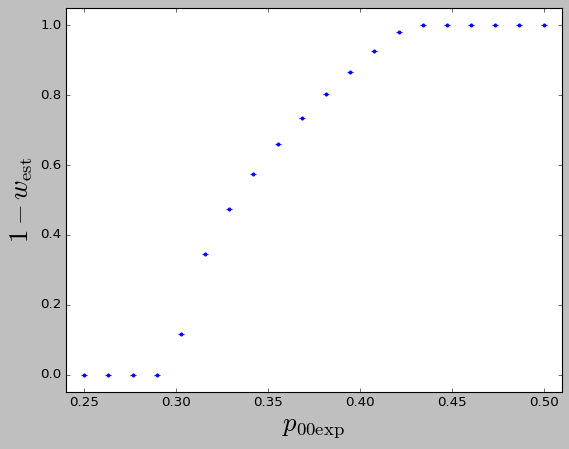

In [ ]:
plt.style.use('classic')

fig, ax = plt.subplots()
ax.errorbar(p00expArray, -1.*wArray + 1., yerr=epswArray, fmt='.', ls='none')

ax.set_xlabel(r'$p_{00\mathrm{exp}}$', fontsize=24)
ax.set_ylabel(r'$1-w_{\mathrm{est}}$', fontsize=24)

padx = 0.01
pady = 0.05
ax.set_xlim([0.25 - padx, 0.50 + padx])
ax.set_ylim([0.00 - pady, 1.00 + pady])

plt.show()

# Testing for correctness

In [6]:
#Testing whether  p00  is evaluated correctly for completely noiseless scenario. Following two checks are for w=0 and w=1

print(p00(0,0,1,1,0,0,1,1)) #p00 value from Bornrule when w=0 and noiseless scenario
print(p00(1,0,1,1,0,0,1,1)) #p00 value from Bornrule when w=1 and noiseless scenario

0.5
0.25


In [7]:
#Testing whether p00sampling and inversion of w is evaluated correctly for completely noiseless scenario.
Nsamples=20

tArray=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
# Parameter related to dephasing and depolarizing noise
T1 = 100.0
T2 = 100.0

# Initial parameter for noisy CNOT
y1 = 0.0
y2 = 0.0

#Noisy measurement
mA = 1.0
mB = 1.0


print(p00samples(0, 20, [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])) # sampling p00 when w =0 in absence of noise
print(p00samples(1, 20, [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])) # sampling p00 when w =1 in absence of noise

print(invertWernerParam(0.25, tArray, 1e-5)) #inversion in absence of any noise when p00 = 0.25
print(invertWernerParam(0.50, tArray, 1e-5)) #inversion in absence of any noise when p00 = 0.50

0.5
0.25
0.99609375
0.0


Testing whether the inversion is correct or not in noiseless scenario. For that we take some arrays of $w \in [0,1]$ (which we call $w_{real}$) and calculate $p_{00}$ and then again inverting to have $w_{est}$. We then plot $w_{est}$ vs $w_{real}$.

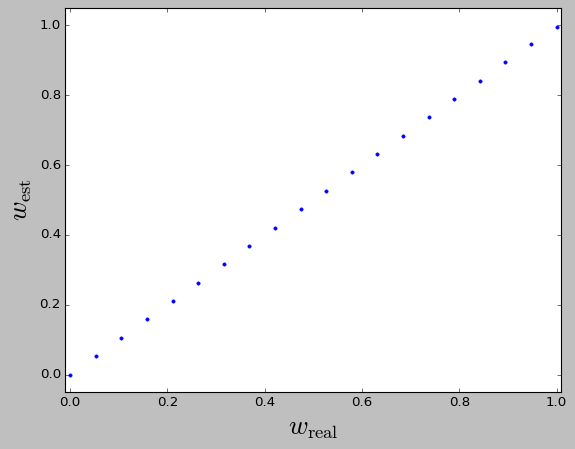

In [8]:
Nsamples = 10

# parameters for noiseless scenario
tArray = np.zeros(Nsamples)
# Some useful numbers
eps = 1e-5
epsilon = 0.01
pSuccess = 0.1

# Parameter related to dephasing and depolarizing noise
T1 = 10.0
T2 = 10.0

# Initial parameter for noisy CNOT
y1 = 0.0
y2 = 0.0

#Noisy measurement
mA = 1.0
mB = 1.0


# initialisation of some w_real taken from 0 to 1
wRealArray = np.linspace(0.0, 1.0, 20, endpoint=True)

# initialisation of p_00 and w_est
p00RealArray = np.zeros(len(wRealArray))
wArray = np.zeros(len(wRealArray))

#First calculate p00 from the w_real and then again inverting to w_est
for q in np.arange(len(wRealArray)):
  p00RealArray[q] = p00expn(wRealArray[q])
  wArray[q] = invertWernerParam(p00RealArray[q], tArray, eps)

#For plotting
plt.style.use('classic')

fig, ax = plt.subplots()
ax.errorbar(wRealArray, wArray, fmt='.', ls='none')

ax.set_xlabel(r'$w_{\mathrm{real}}$', fontsize=24)
ax.set_ylabel(r'$w_{\mathrm{est}}$', fontsize=24)

padx = 0.01
pady = 0.05
ax.set_xlim([0.0 - padx, 1.0 + padx])
ax.set_ylim([0.0 - pady, 1.0 + pady])

plt.show()

Testing whether the inversion is correct or not in presence of noisy CNOT only. All other things remain noiseless. For that we take some arrays of $w \in [0,1]$ (which we call $w_{real}$) and calculate $p_{00}$ and then again inverting to have $w_{est}$. We then plot $w_{est}$ vs $w_{real}$.

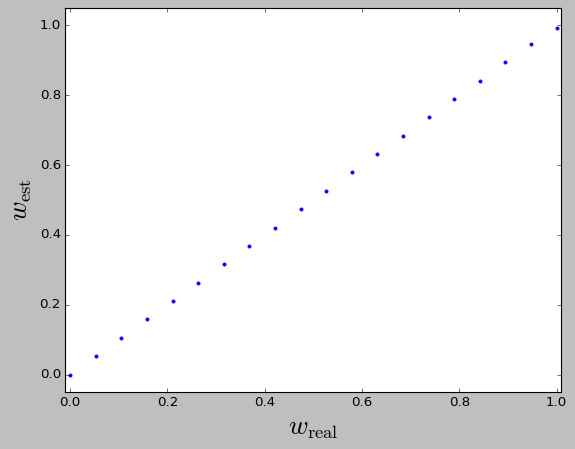

In [9]:
Nsamples = 10

# parameters for noiseless state and measurements however CNOTs are noisy
tArray = np.zeros(Nsamples)
# Some useful numbers
eps = 1e-5
epsilon = 0.01
pSuccess = 0.1

# Parameter related to dephasing and depolarizing noise
T1 = 10.0
T2 = 10.0

# Initial parameter for noisy CNOT
y1 = 0.2
y2 = 0.2

#Noisy measurement
mA = 1.0
mB = 1.0


# initialisation of some w_real taken from 0 to 1
wRealArray = np.linspace(0.0, 1.0, 20, endpoint=True)

# initialisation of p_00 and w_est
p00RealArray = np.zeros(len(wRealArray))
wArray = np.zeros(len(wRealArray))

#First calculate p00 from the w_real and then again inverting to w_est
for q in np.arange(len(wRealArray)):
  p00RealArray[q] = p00expn(wRealArray[q])
  wArray[q] = invertWernerParam(p00RealArray[q], tArray, eps)

#For plotting
plt.style.use('classic')

fig, ax = plt.subplots()
ax.errorbar(wRealArray, wArray, fmt='.', ls='none')

ax.set_xlabel(r'$w_{\mathrm{real}}$', fontsize=24)
ax.set_ylabel(r'$w_{\mathrm{est}}$', fontsize=24)

padx = 0.01
pady = 0.05
ax.set_xlim([0.0 - padx, 1.0 + padx])
ax.set_ylim([0.0 - pady, 1.0 + pady])

plt.show()

Testing whether the inversion is correct or not when the states are noisy only. All other things remain noiseless. For that we take some arrays of $w \in [0,1]$ (which we call $w_{real}$) and calculate $p_{00}$ and then again inverting to have $w_{est}$. We then plot $w_{est}$ vs $w_{real}$.

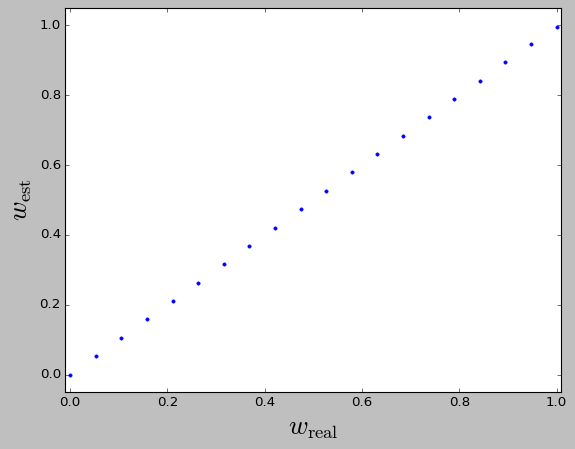

In [10]:
Nsamples = 10

# parameters when states are undergoing noise but all other parameters are noiseless
tArray = np.random.geometric(pSuccess, Nsamples)
# Some useful numbers
eps = 1e-5
epsilon = 0.01
pSuccess = 0.1

# Parameter related to dephasing and depolarizing noise
T1 = 100.0
T2 = 100.0

# Initial parameter for noisy CNOT
y1 = 0.0
y2 = 0.0

#Noisy measurement
mA = 1.0
mB = 1.0


# initialisation of some w_real taken from 0 to 1
wRealArray = np.linspace(0.0, 1.0, 20, endpoint=True)

# initialisation of p_00 and w_est
p00RealArray = np.zeros(len(wRealArray))
wArray = np.zeros(len(wRealArray))

#First calculate p00 from the w_real and then again inverting to w_est
for q in np.arange(len(wRealArray)):
  p00RealArray[q] = p00expn(wRealArray[q])
  wArray[q] = invertWernerParam(p00RealArray[q], tArray, eps)

#For plotting
plt.style.use('classic')

fig, ax = plt.subplots()
ax.errorbar(wRealArray, wArray, fmt='.', ls='none')

ax.set_xlabel(r'$w_{\mathrm{real}}$', fontsize=24)
ax.set_ylabel(r'$w_{\mathrm{est}}$', fontsize=24)

padx = 0.01
pady = 0.05
ax.set_xlim([0.0 - padx, 1.0 + padx])
ax.set_ylim([0.0 - pady, 1.0 + pady])

plt.show()

Testing whether the inversion is correct or not in presence of general noise. For that we take some arrays of $w \in [0,1]$ (which we call $w_{real}$) and calculate $p_{00}$ and then again inverting to have $w_{est}$. We then plot $w_{est}$ vs $w_{real}$.

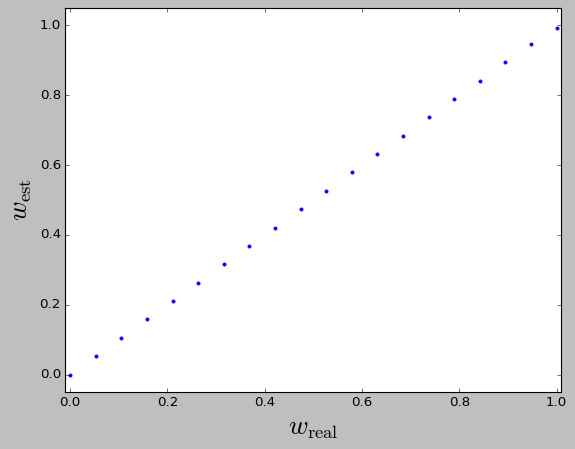

In [11]:
Nsamples = 10

# parameters for some general noisy scenario
tArray = np.random.geometric(pSuccess, Nsamples)
# Some useful numbers
eps = 1e-5
epsilon = 0.01
pSuccess = 0.1

# Parameter related to dephasing and depolarizing noise
T1 = 100.0
T2 = 100.0

# Initial parameter for noisy CNOT
y1 = 0.1
y2 = 0.1

#Noisy measurement
mA = 0.8
mB = 0.8


# initialisation of some w_real taken from 0 to 1
wRealArray = np.linspace(0.0, 1.0, 20, endpoint=True)

# initialisation of p_00 and w_est
p00RealArray = np.zeros(len(wRealArray))
wArray = np.zeros(len(wRealArray))

#First calculate p00 from the w_real and then again inverting to w_est
for q in np.arange(len(wRealArray)):
  p00RealArray[q] = p00expn(wRealArray[q])
  wArray[q] = invertWernerParam(p00RealArray[q], tArray, eps)

#For plotting
plt.style.use('classic')

fig, ax = plt.subplots()
ax.errorbar(wRealArray, wArray, fmt='.', ls='none')

ax.set_xlabel(r'$w_{\mathrm{real}}$', fontsize=24)
ax.set_ylabel(r'$w_{\mathrm{est}}$', fontsize=24)

padx = 0.01
pady = 0.05
ax.set_xlim([0.0 - padx, 1.0 + padx])
ax.set_ylim([0.0 - pady, 1.0 + pady])

plt.show()

Noiseless experiment. Consider $w \in [0,1]$ and then simulate experiment, obtain $p_{00}$, invert from $p_{00}$ to $w_{est}$.

In [12]:
Nsamples = 100000

# parameters for noiseless scenario
tArray = np.zeros(Nsamples)
# Some useful numbers
eps = 1e-5
epsilon = 0.01
pSuccess = 0.1

# Parameter related to dephasing and depolarizing noise
T1 = 10.0
T2 = 10.0

# Initial parameter for noisy CNOT
y1 = 0.0
y2 = 0.0

#Noisy measurement
mA = 1.0
mB = 1.0


# initialisation of some w_real taken from 0 to 1
wRealArray = np.linspace(0.0, 1.0, 20, endpoint=True)
p00RealArray = np.zeros(len(wRealArray))

# initialisation of p00experimental array
p00EstArray = np.zeros(len(wRealArray))

# initialisation of p_00 and w_est
wEstArray = np.zeros(len(wRealArray))
p00EpsilonplusEstArray = np.zeros(len(wRealArray))
p00EpsilonminusEstArray = np.zeros(len(wRealArray))
wEpsilonplusEstArray = np.zeros(len(wRealArray))
wEpsilonminusEstArray = np.zeros(len(wRealArray))
epsilonw = np.zeros(len(wRealArray))

#First calculate p00 from the w_real and then again inverting to w_est
for q in np.arange(len(wRealArray)):
  print('iteration',q)
  p00RealArray[q] = p00expn(wRealArray[q])
  p00EstArray[q] = p00Experimental(wRealArray[q], Nsamples, pSuccess, tArray)
  wEstArray[q] = invertWernerParam(p00EstArray[q], tArray, eps)
  #p00EpsilonplusEstArray[q] = p00EstArray[q] + epsilon #plus array is not required since minus array is sufficient for our purpose
  p00EpsilonminusEstArray[q] = p00EstArray[q] - epsilon
  #wEpsilonplusEstArray[q] = invertWernerParam(p00EpsilonplusEstArray[q], tArray, eps)
  wEpsilonminusEstArray[q] = invertWernerParam(p00EpsilonminusEstArray[q], tArray, eps)
  epsilonw[q] = abs(wEpsilonminusEstArray[q] - wEstArray[q])

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19


In [13]:
with open('estimation_w_noiseless_100000.txt','w') as f:
    for q in np.arange(len(wRealArray)):
        f.write(str(wRealArray[q]) + '\t' + str(p00RealArray[q]) + '\t' + str(p00EstArray[q]) + '\t' + str(wEstArray[q]) + '\t' + str(p00EpsilonminusEstArray[q]) + '\t'+ str(wEpsilonminusEstArray[q]) + '\t'+ str(epsilonw[q]) + '\n' )

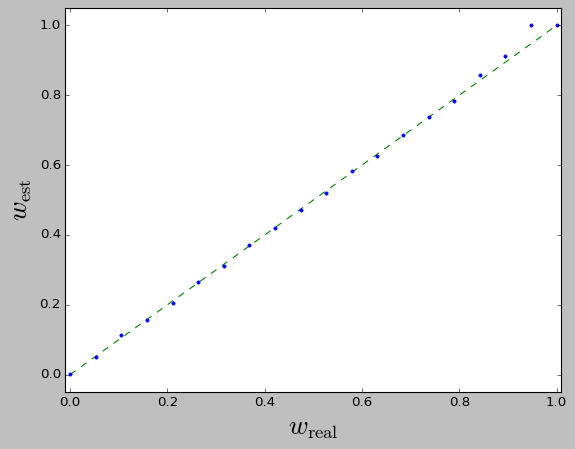

In [15]:
#For plotting
plt.style.use('classic')

fig, ax = plt.subplots()
ax.errorbar(wRealArray, wEstArray, fmt='.', ls='none')
ax.plot([0.,1.],[0.,1.], ls = 'dashed')

ax.set_xlabel(r'$w_{\mathrm{real}}$', fontsize=24)
ax.set_ylabel(r'$w_{\mathrm{est}}$', fontsize=24)

padx = 0.01
pady = 0.05
ax.set_xlim([0.0 - padx, 1.0 + padx])
ax.set_ylim([0.0 - pady, 1.0 + pady])

plt.show()

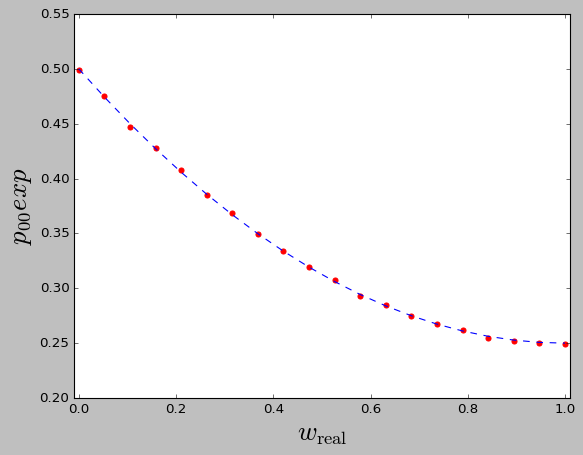

In [18]:
#For plotting
plt.style.use('classic')

fig, ax = plt.subplots()
ax.errorbar(wRealArray, p00RealArray, fmt='', ls='dashed')
ax.scatter(wRealArray, p00EstArray, color='red')

ax.set_xlabel(r'$w_{\mathrm{real}}$', fontsize=24)
ax.set_ylabel(r'$p_{00}exp$', fontsize=24)

padx = 0.01
pady = 0.05
ax.set_xlim([0.0 - padx, 1.0 + padx])
ax.set_ylim([0.25 - pady, 0.5 + pady])

plt.show()

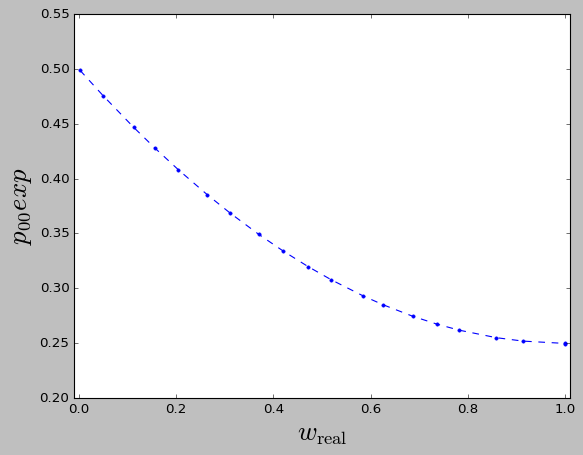

In [20]:
#For plotting
plt.style.use('classic')

fig, ax = plt.subplots()
ax.errorbar(wEstArray, p00EstArray,  fmt='.', ls='dashed')

ax.set_xlabel(r'$w_{\mathrm{real}}$', fontsize=24)
ax.set_ylabel(r'$p_{00}exp$', fontsize=24)

padx = 0.01
pady = 0.05
ax.set_xlim([0.0 - padx, 1.0 + padx])
ax.set_ylim([0.25 - pady, 0.5 + pady])

plt.show()

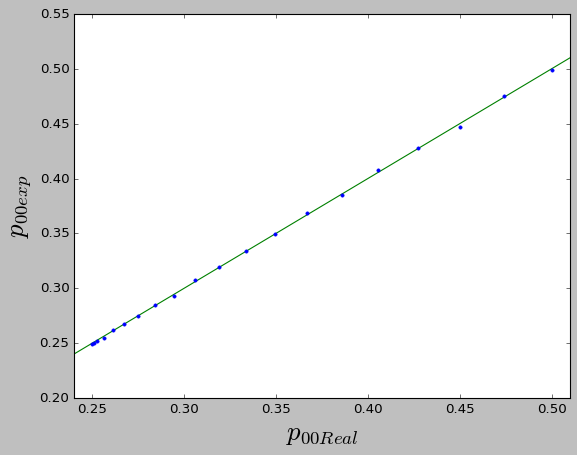

In [23]:
#For plotting
plt.style.use('classic')

fig, ax = plt.subplots()
ax.errorbar(p00RealArray, p00EstArray,  fmt='.', ls='none')
ax.plot([0.,1.],[0.,1.], ls = 'solid')
ax.set_xlabel(r'$p_{00Real}$', fontsize=24)
ax.set_ylabel(r'$p_{00exp}$', fontsize=24)

padx = 0.01
pady = 0.05
ax.set_xlim([0.25 - padx, 0.5 + padx])
ax.set_ylim([0.25 - pady, 0.5 + pady])

plt.show()

Noisy experiment. Consider $w \in [0,1]$ and then simulate experiment, obtain $p_{00}$, invert from $p_{00}$ to $w_{est}$.

In [ ]:
Nsamples = 100000

# parameters for noiseless scenario
tArray = np.zeros(Nsamples)
# Some useful numbers
eps = 1e-5
epsilon = 0.01
pSuccess = 0.1

# Parameter related to dephasing and depolarizing noise
T1 = 100.0
T2 = 100.0

# Initial parameter for noisy CNOT
y1 = 0.1
y2 = 0.1

#Noisy measurement
mA = 0.9
mB = 0.9


# initialisation of some w_real taken from 0 to 1
wRealArray = np.linspace(0.0, 1.0, 20, endpoint=True)
p00RealArray = np.zeros(len(wRealArray))

# initialisation of p00experimental array
p00EstArray = np.zeros(len(wRealArray))

# initialisation of p_00 and w_est
wEstArray = np.zeros(len(wRealArray))
p00EpsilonplusEstArray = np.zeros(len(wRealArray))
p00EpsilonminusEstArray = np.zeros(len(wRealArray))
wEpsilonplusEstArray = np.zeros(len(wRealArray))
wEpsilonminusEstArray = np.zeros(len(wRealArray))
epsilonw = np.zeros(len(wRealArray))

#First calculate p00 from the w_real and then again inverting to w_est
for q in np.arange(len(wRealArray)):
  print('iteration',q)
  p00RealArray[q] = p00expn(wRealArray[q])
  p00EstArray[q] = p00Experimental(wRealArray[q], Nsamples, pSuccess, tArray)
  wEstArray[q] = invertWernerParam(p00EstArray[q], tArray, eps)
  #p00EpsilonplusEstArray[q] = p00EstArray[q] + epsilon #plus array is not required since minus array is sufficient for our purpose
  p00EpsilonminusEstArray[q] = p00EstArray[q] - epsilon
  #wEpsilonplusEstArray[q] = invertWernerParam(p00EpsilonplusEstArray[q], tArray, eps)
  wEpsilonminusEstArray[q] = invertWernerParam(p00EpsilonminusEstArray[q], tArray, eps)
  epsilonw[q] = abs(wEpsilonminusEstArray[q] - wEstArray[q])

iteration 0
iteration 1
iteration 2
iteration 3


In [ ]:
with open('estimation_w_noisy_100000.txt','w') as f:
    for q in np.arange(len(wRealArray)):
        f.write(str(wRealArray[q]) + '\t' + str(p00RealArray[q]) + '\t' + str(p00EstArray[q]) + '\t' + str(wEstArray[q]) + '\t' + str(p00EpsilonminusEstArray[q]) + '\t'+ str(wEpsilonminusEstArray[q]) + '\t'+ str(epsilonw[q]) + '\n' )